# Batch QEP Regression

## Introduction

In this notebook, we demonstrate how to train Gaussian processes in the batch setting -- that is, given `b` training sets and `b` separate test sets, QPyTorch is capable of training independent QEPs on each training set and then testing each QEP separately on each test set in parallel. This can be extremely useful if, for example, you would like to do k-fold cross validation.

**Note:** When operating in batch mode, we do **NOT** account for any correlations between the different functions being modeled. If you wish to do this, see the multitask examples instead.

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline

## Set up training data

In the next cell, we set up the training data for this example. For the x values, we'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels. For the training labels, we'll be modeling four functions independently in batch mode: two sine functions with different periods and two cosine functions with different periods. 

In total, `train_x` will be `4 x 100 x 1` (`b x n x 1`) and `train_y` will be `4 x 100` (`b x n`)

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100).view(1, -1, 1).repeat(4, 1, 1)
# True functions are sin(2pi x), cos(2pi x), sin(pi x), cos(pi x)
sin_y = torch.sin(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
sin_y_short = torch.sin(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y = torch.cos(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y_short = torch.cos(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
train_y = torch.cat((sin_y, sin_y_short, cos_y, cos_y_short)).squeeze(-1)

## Setting up the model

The next cell adapts the model from the Simple QEP regression tutorial to the batch setting. Not much changes: the only modification is that we add a `batch_shape` to the mean and covariance modules. What this does internally is replicates the mean constant and lengthscales `b` times so that we learn a different value for each function in the batch.

In [4]:
# We will use the simplest form of QEP model, exact inference
POWER = 1.0
class ExactQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactQEPModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean(batch_shape=torch.Size([4]))
        self.covar_module = qpytorch.kernels.ScaleKernel(
            qpytorch.kernels.MaternKernel(batch_shape=torch.Size([4])),
            batch_shape=torch.Size([4])
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

# initialize likelihood and model
likelihood = qpytorch.likelihoods.QExponentialLikelihood(batch_shape=torch.Size([4]), power=torch.tensor(POWER))
model = ExactQEPModel(train_x, train_y, likelihood)

## Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the q-exponential process. This loop is nearly identical to the simple QEP regression setting with one key difference. Now, the call through the mariginal log likelihood returns `b` losses, one for each QEP. Since we have different parameters for each QEP, we can simply sum these losses before calling `backward`.

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y).sum()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 5.821
Iter 2/50 - Loss: 5.602
Iter 3/50 - Loss: 5.384
Iter 4/50 - Loss: 5.170
Iter 5/50 - Loss: 4.963
Iter 6/50 - Loss: 4.766
Iter 7/50 - Loss: 4.582
Iter 8/50 - Loss: 4.413
Iter 9/50 - Loss: 4.263
Iter 10/50 - Loss: 4.131
Iter 11/50 - Loss: 4.014
Iter 12/50 - Loss: 3.909
Iter 13/50 - Loss: 3.814
Iter 14/50 - Loss: 3.725
Iter 15/50 - Loss: 3.641
Iter 16/50 - Loss: 3.559
Iter 17/50 - Loss: 3.479
Iter 18/50 - Loss: 3.400
Iter 19/50 - Loss: 3.321
Iter 20/50 - Loss: 3.242
Iter 21/50 - Loss: 3.163
Iter 22/50 - Loss: 3.083
Iter 23/50 - Loss: 3.002
Iter 24/50 - Loss: 2.921
Iter 25/50 - Loss: 2.838
Iter 26/50 - Loss: 2.755
Iter 27/50 - Loss: 2.670
Iter 28/50 - Loss: 2.585
Iter 29/50 - Loss: 2.499
Iter 30/50 - Loss: 2.412
Iter 31/50 - Loss: 2.325
Iter 32/50 - Loss: 2.237
Iter 33/50 - Loss: 2.149
Iter 34/50 - Loss: 2.061
Iter 35/50 - Loss: 1.972
Iter 36/50 - Loss: 1.884
Iter 37/50 - Loss: 1.796
Iter 38/50 - Loss: 1.709
Iter 39/50 - Loss: 1.621
Iter 40/50 - Loss: 1.535
Iter 41/5

## Make predictions with the model

Making predictions with batched QEPs is straight forward: we simply call the model (and optionally the likelihood) on batch `b x t x 1` test data. The resulting `MultivariateQExponential` will have a `b x n` mean and a `b x n x n` covariance matrix. Standard calls like `preds.confidence_region()` still function -- for example `preds.var()` returns a `b x n` set of predictive variances.

In the cell below, we make predictions in batch mode for the four functions and plot the QEP fit for each one.

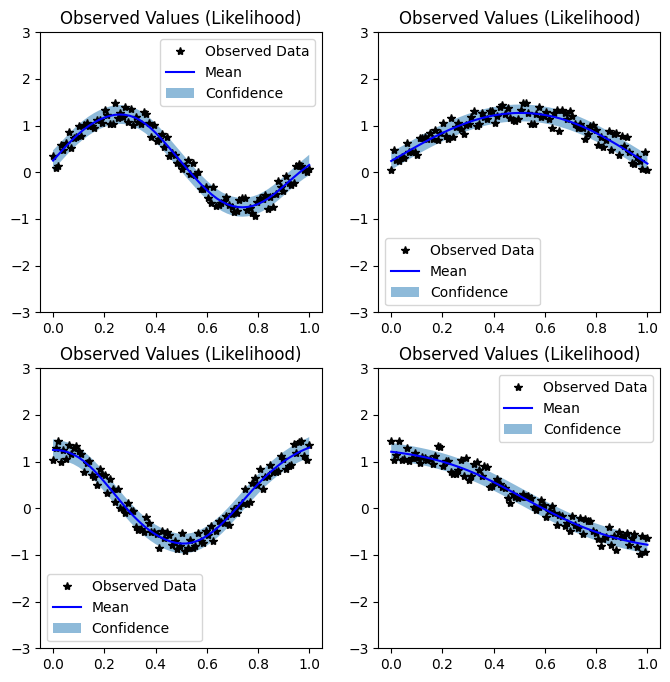

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, ((y1_ax, y2_ax), (y3_ax, y4_ax)) = plt.subplots(2, 2, figsize=(8, 8))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51).view(1, -1, 1).repeat(4, 1, 1)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()


# Plot training data as black stars
y1_ax.plot(train_x[0].detach().numpy(), train_y[0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x[0].squeeze().numpy(), mean[0, :].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x[0].squeeze().numpy(), lower[0, :].numpy(), upper[0, :].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

y2_ax.plot(train_x[1].detach().numpy(), train_y[1].detach().numpy(), 'k*')
y2_ax.plot(test_x[1].squeeze().numpy(), mean[1, :].numpy(), 'b')
y2_ax.fill_between(test_x[1].squeeze().numpy(), lower[1, :].numpy(), upper[1, :].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

y3_ax.plot(train_x[2].detach().numpy(), train_y[2].detach().numpy(), 'k*')
y3_ax.plot(test_x[2].squeeze().numpy(), mean[2, :].numpy(), 'b')
y3_ax.fill_between(test_x[2].squeeze().numpy(), lower[2, :].numpy(), upper[2, :].numpy(), alpha=0.5)
y3_ax.set_ylim([-3, 3])
y3_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y3_ax.set_title('Observed Values (Likelihood)')

y4_ax.plot(train_x[3].detach().numpy(), train_y[3].detach().numpy(), 'k*')
y4_ax.plot(test_x[3].squeeze().numpy(), mean[3, :].numpy(), 'b')
y4_ax.fill_between(test_x[3].squeeze().numpy(), lower[3, :].numpy(), upper[3, :].numpy(), alpha=0.5)
y4_ax.set_ylim([-3, 3])
y4_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y4_ax.set_title('Observed Values (Likelihood)')

None